# Prediction of Obesity Risk - One of Kaggle's competitions

## 1. Import necessary libraries

In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from catboost import CatBoostClassifier, Pool

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report


import warnings
warnings.filterwarnings('ignore')

## 2. Load & Explore Data

In [47]:
train_data = pd.read_csv(r"C:\Users\Hussein\Desktop\Multi-Class Prediction of Obesity Risk\train.csv")
train_data.shape

(20758, 18)

In [48]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20758 entries, 0 to 20757
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              20758 non-null  int64  
 1   Gender                          20758 non-null  object 
 2   Age                             20758 non-null  float64
 3   Height                          20758 non-null  float64
 4   Weight                          20758 non-null  float64
 5   family_history_with_overweight  20758 non-null  object 
 6   FAVC                            20758 non-null  object 
 7   FCVC                            20758 non-null  float64
 8   NCP                             20758 non-null  float64
 9   CAEC                            20758 non-null  object 
 10  SMOKE                           20758 non-null  object 
 11  CH2O                            20758 non-null  float64
 12  SCC                             

In [49]:
train_data.sample(3)

,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
16230,16230,Female,18.178023,1.599486,80.000000,yes,yes,2.000000,1.015488,Sometimes,no,1.000000,no,0.562118,1.094941,no,Public_Transportation,Obesity_Type_I
2506,2506,Male,26.624342,1.751067,119.117122,yes,yes,3.000000,3.000000,Sometimes,no,2.511399,no,0.090147,0.000000,Sometimes,Public_Transportation,Obesity_Type_II
17106,17106,Male,17.377131,1.791867,58.830710,yes,yes,2.483979,3.762778,Sometimes,no,2.000000,no,2.000000,0.930051,no,Automobile,Insufficient_Weight


In [50]:
# check for null values:
count_null = train_data.isnull().sum()
count_null

id                                0
Gender                            0
Age                               0
Height                            0
Weight                            0
family_history_with_overweight    0
FAVC                              0
FCVC                              0
NCP                               0
CAEC                              0
SMOKE                             0
CH2O                              0
SCC                               0
FAF                               0
TUE                               0
CALC                              0
MTRANS                            0
NObeyesdad                        0
dtype: int64

In [51]:
# the dataset doesn't hold any null values.

# check for duplicates, and remove, if any

count_duplicates = train_data.duplicated().sum()
print('Count of duplicated rows: ', count_duplicates)
print('Shape of data: ', train_data.shape)

if count_duplicates > 0:
    train_data.drop_duplicates(inplace=True)
    print('Shape of data: ', train_data.shape)

Count of duplicated rows:  0
Shape of data:  (20758, 18)


## 3. Analysis

#### - Describe categorical data:

In [52]:
train_data.describe(include='object')

,Gender,family_history_with_overweight,FAVC,CAEC,SMOKE,SCC,CALC,MTRANS,NObeyesdad
count,20758,20758,20758,20758,20758,20758,20758,20758,20758
unique,2,2,2,4,2,2,3,5,7
top,Female,yes,yes,Sometimes,no,no,Sometimes,Public_Transportation,Obesity_Type_III
freq,10422,17014,18982,17529,20513,20071,15066,16687,4046


In [53]:
for col in train_data.select_dtypes(include='object'):
    print(f'Unique values of {col}: \n {train_data[col].unique()}')
    print('*'*50)

Unique values of Gender: 
 ['Male' 'Female']
**************************************************
Unique values of family_history_with_overweight: 
 ['yes' 'no']
**************************************************
Unique values of FAVC: 
 ['yes' 'no']
**************************************************
Unique values of CAEC: 
 ['Sometimes' 'Frequently' 'no' 'Always']
**************************************************
Unique values of SMOKE: 
 ['no' 'yes']
**************************************************
Unique values of SCC: 
 ['no' 'yes']
**************************************************
Unique values of CALC: 
 ['Sometimes' 'no' 'Frequently']
**************************************************
Unique values of MTRANS: 
 ['Public_Transportation' 'Automobile' 'Walking' 'Motorbike' 'Bike']
**************************************************
Unique values of NObeyesdad: 
 ['Overweight_Level_II' 'Normal_Weight' 'Insufficient_Weight'
 'Obesity_Type_III' 'Obesity_Type_II' 'Overweight_Level_I'


#### - Describe quantitive data

In [54]:
train_data.describe(include='number')

,id,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE
count,20758.00000,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000
mean,10378.50000,23.841804,1.700245,87.887768,2.445908,2.761332,2.029418,0.981747,0.616756
std,5992.46278,5.688072,0.087312,26.379443,0.533218,0.705375,0.608467,0.838302,0.602113
min,0.00000,14.000000,1.450000,39.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,5189.25000,20.000000,1.631856,66.000000,2.000000,3.000000,1.792022,0.008013,0.000000
50%,10378.50000,22.815416,1.700000,84.064875,2.393837,3.000000,2.000000,1.000000,0.573887
75%,15567.75000,26.000000,1.762887,111.600553,3.000000,3.000000,2.549617,1.587406,1.000000
max,20757.00000,61.000000,1.975663,165.057269,3.000000,4.000000,3.000000,3.000000,2.000000


#### - Find corrleation between quantitive columns:

<Axes: >

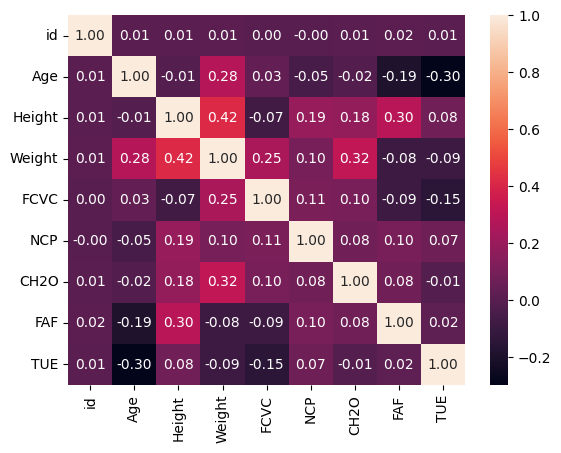

In [55]:
sns.heatmap(train_data.select_dtypes(include='number').corr(), annot=True, fmt='.2f')

## 4. Data Preprocessing:

#### - Scale the entries of Age, Weight columns:

In [56]:
standard_scaler = StandardScaler()
train_data['Age'] = standard_scaler.fit_transform(train_data[['Age']])
train_data['Weight'] = standard_scaler.fit_transform(train_data[['Weight']])
train_data.head()

,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,0,Male,0.105699,1.699998,-0.235713,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II
1,1,Female,-1.027052,1.560000,-1.170931,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,Normal_Weight
2,2,Female,-1.027052,1.711460,-1.430012,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight
3,3,Female,-0.507929,1.710730,1.644770,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III
4,4,Male,1.371197,1.914186,0.224054,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II


#### - Drop unnecessary ID column:

In [57]:
train_data = train_data.drop('id', axis=1)

## 5. Machine Learning

#### - Split the dataset column-wise into features (X) and target (y)

In [58]:
X = train_data.drop(columns=['NObeyesdad']).values
y = train_data['NObeyesdad'].values

#### - Split the dataset row-wise into train and test

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### - Handle categorical columns, and prepare them for the model

In [60]:
categorical_features = ['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS']
df = train_data.copy()
df = df.drop('NObeyesdad', axis=1)
feature_names = list(df.columns)

# Get the indices of categorical features based on their positions
categorical_features_indices = [i for i, col in enumerate(feature_names) if col in categorical_features]

# Create Pool objects using indices for categorical features
train_pool = Pool(X_train, y_train, cat_features=categorical_features_indices)
test_pool = Pool(X_test, y_test, cat_features=categorical_features_indices)

#### - Build and initialize the CatBoost Classifier

In [61]:
model = CatBoostClassifier(
    iterations=1000,          # Number of trees
    learning_rate=0.05,        # Learning rate
    depth=6,                  # Depth of the tree
    eval_metric='Accuracy',   # Evaluation metric
    random_seed=42,           # For reproducibility
    od_type='Iter',           # Use overfitting detector
    od_wait=20,               # Wait for 50 iterations before stopping
    logging_level='Silent'    # To suppress training output
)


#### - Training and fitting the model

In [62]:
model.fit(
    train_pool,
    eval_set=test_pool,
    verbose=100,
    early_stopping_rounds=50
)

#### - Evaluation on Test subset

Test Accuracy: 90.66%
Classification Report:
                     precision    recall  f1-score   support

Insufficient_Weight       0.94      0.94      0.94       524
      Normal_Weight       0.88      0.87      0.88       626
     Obesity_Type_I       0.90      0.88      0.89       543
    Obesity_Type_II       0.97      0.98      0.97       657
   Obesity_Type_III       1.00      1.00      1.00       804
 Overweight_Level_I       0.78      0.79      0.79       484
Overweight_Level_II       0.81      0.81      0.81       514

           accuracy                           0.91      4152
          macro avg       0.90      0.90      0.90      4152
       weighted avg       0.91      0.91      0.91      4152



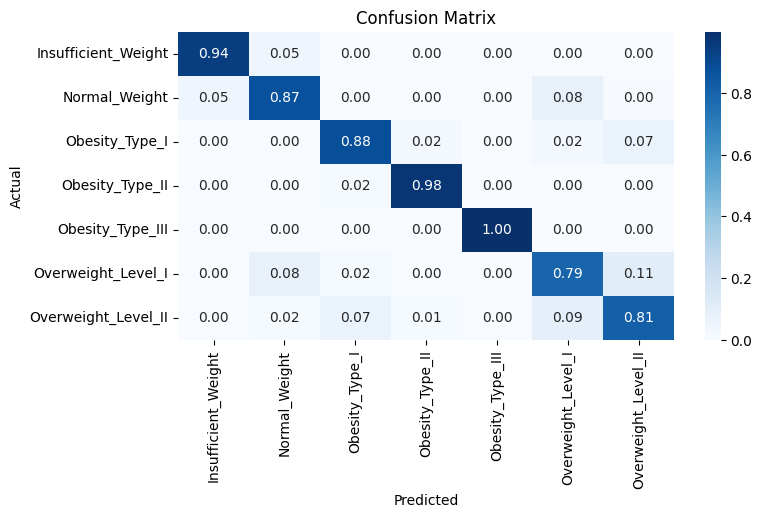

In [63]:
# Make predictions
y_pred = model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy * 100:.0f}%")

#Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred, normalize='true')

# Plot confusion matrix
plt.figure(figsize=(8,4))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

#### - Get and visualize feature importances

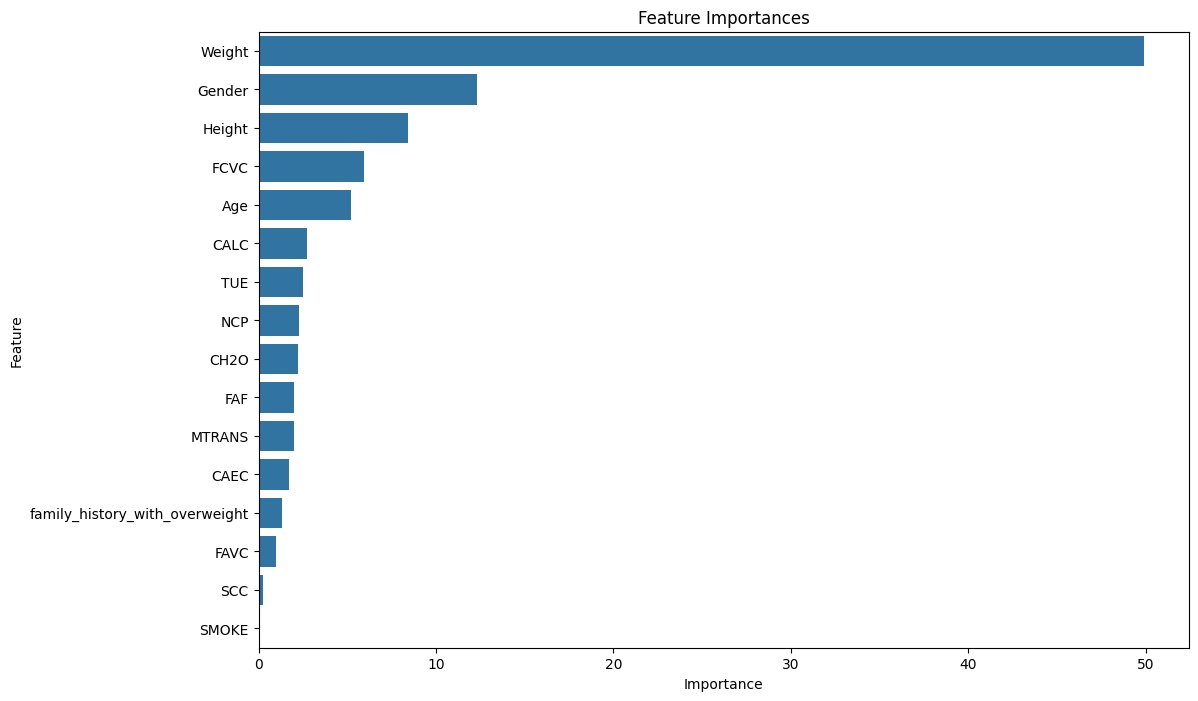

In [64]:
feature_importances = model.get_feature_importance(train_pool)

# Create a DataFrame for visualization
importances_df = pd.DataFrame({ 'Feature': feature_names, 'Importance': feature_importances})

# Sort the DataFrame by importance
importances_df = importances_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(12,8))
sns.barplot(x='Importance', y='Feature', data=importances_df)
plt.title('Feature Importances')
plt.show()


#### - Let the model generalize on the test file:

In [93]:
test_data = pd.read_csv(r"C:\Users\Hussein\Desktop\Multi-Class Prediction of Obesity Risk\test.csv")

# drop id column
test_file_data = test_data.drop('id', axis=1)

# scale Age and Weight
test_file_data['Age'] = standard_scaler.fit_transform(test_file_data[['Age']])
test_file_data['Weight'] = standard_scaler.fit_transform(test_file_data[['Weight']])

X_test_file = test_file_data.values

# Make predictions
y_pred_test_file = model.predict(X_test_file)
y_pred_test_file = y_pred_test_file.flatten()
y_pred_test_file

array(['Obesity_Type_II', 'Overweight_Level_I', 'Obesity_Type_III', ...,
       'Insufficient_Weight', 'Normal_Weight', 'Obesity_Type_II'],
      dtype=object)

In [94]:
submission_df = pd.DataFrame({"id": test_data['id'], "NObeyesdad": y_pred_test_file})
submission_df.to_csv("submission_catBoost.csv", index=False)
submission_df

,id,NObeyesdad
0,20758,Obesity_Type_II
1,20759,Overweight_Level_I
2,20760,Obesity_Type_III
3,20761,Obesity_Type_I
4,20762,Obesity_Type_III
...,...,...
13835,34593,Overweight_Level_II
13836,34594,Normal_Weight
13837,34595,Insufficient_Weight
13838,34596,Normal_Weight


### The CatBoost classifier scored an accuracy of 89.92% on the test file of the Obesity Risk predicition

![Prediction of Obesity Risk.png](<attachment:Prediction of Obesity Risk.png>)
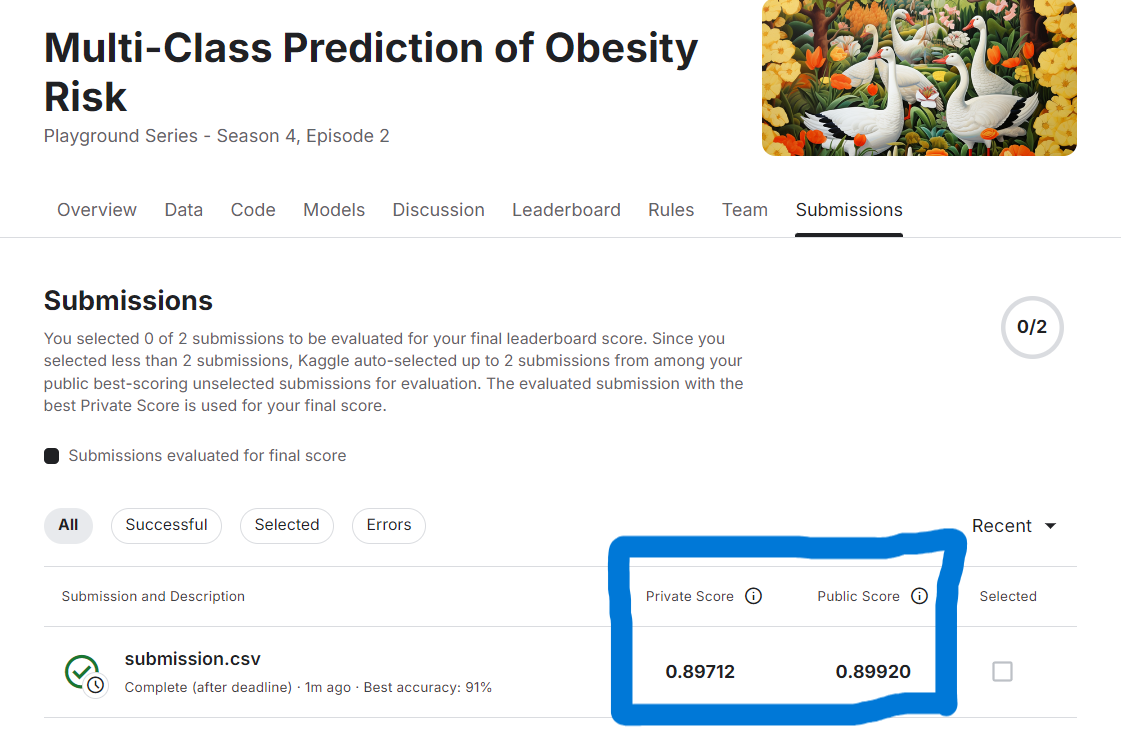

## 6. Other Machine Learning Models

In [140]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder

#### - Convert/transform categorical data to numeric:

In [141]:
label_encoder = LabelEncoder()

for col in train_data.select_dtypes(include='object'):
    train_data[col] = label_encoder.fit_transform(train_data[col])


#### - Split the dataset:

In [142]:
x = train_data.drop('NObeyesdad', axis=1)
y = train_data['NObeyesdad']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

#### - Build, Train and Test the classifiers:

In [157]:
algorithms = ['LogisticRegression', 'SVM', 'RandomForeset', 'GradientBoosting', 'XGB', 'GaussianNB', 'KNeighbors', 'MLP' ]
accuracies = []
def fit_model(model):
    model.fit(x_train, y_train)
    y_pre = model.predict(x_test)
    accuracy = accuracy_score(y_true=y_test, y_pred=y_pre)
    accuracies.append(accuracy)

In [158]:
lr = LogisticRegression()
svmc = SVC()
rfc = RandomForestClassifier()
gbc = GradientBoostingClassifier()
xgbc = XGBClassifier()
gnb = GaussianNB()
knc = KNeighborsClassifier()
mlp = MLPClassifier()

In [159]:
fit_model(lr)
fit_model(svmc)
fit_model(rfc)
fit_model(gbc)
fit_model(xgbc)
fit_model(gnb)
fit_model(knc)
fit_model(mlp)

results = pd.DataFrame({'Algorithm': algorithms, 'Accuracy': accuracies})
results.sort_values(by='Accuracy', ascending=False)

,Algorithm,Accuracy
3,GradientBoosting,0.902697
4,XGB,0.900289
2,RandomForeset,0.895954
7,MLP,0.857659
1,SVM,0.852360
0,LogisticRegression,0.805154
6,KNeighbors,0.770472
5,GaussianNB,0.663054
